# 0.데이터 설명
- 유튜브 메인 페이지 "탐색/인기" 섹션에서 기초한 데이터셋
- 특정 기간동안의 동영상 트렌드 기록/연구 및 데이터를 다양한 관점으로 관찰하고 인사이트를 도출하는데 사용됨
  - 유튜브에서 인기 동영상으로 선택된 비디오 기준으로 가공
  - 1일 1회 수집
  - 각 비디오가 인기 동영상에 처음 포착된 시점과 사라진 시점의 데이터가 기록됨

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 나눔폰트 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (47.6 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [3]:
# 데이터 전처리
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime, timedelta

# tag 전처리 및 시각화
from collections import Counter
plt.rc('font', family='NanumBarunGothic') # 한글깨짐 방지

# 신규지표 생성
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [4]:
path = "/content/drive/MyDrive/Colab Notebooks/wanted_preonboarding/assignments/analysis/pretest_data.csv"
df = pd.read_csv(path)

# 1.EDA (+ preprocessing)

## 1.1.전체 데이터 확인

In [5]:
# 데이터 shape 확인
df.shape

(2644, 25)

In [6]:
# 데이터 자료형 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   video_id                  2644 non-null   object
 1   channel_id                2644 non-null   object
 2   published_date            2644 non-null   object
 3   category_name             2644 non-null   object
 4   duration                  2644 non-null   object
 5   tags                      2274 non-null   object
 6   description               2604 non-null   object
 7   on_trending_date          2644 non-null   object
 8   off_trending_date         2644 non-null   object
 9   on_rank                   2644 non-null   int64 
 10  off_rank                  2644 non-null   int64 
 11  on_views                  2644 non-null   int64 
 12  off_views                 2644 non-null   int64 
 13  on_likes                  2644 non-null   int64 
 14  off_likes               

## 1.2.중복값 확인 / 처리

In [7]:
# 전체적으로 중복값 확인 -> 중복 X
df.duplicated().unique() 

array([False])

In [8]:
# video_id 중복값 확인 -> video_id는 중복값 존재
assert df.shape[0] != len(df['video_id'].unique())

# 전체 행수 2644 중 video_id 수는 2643개로 2개의 행이 video_id 중복
print(f"전체 video_id : {len(df['video_id'].unique())} 개")

# 중복 video_id 확인
for key, value in df['video_id'].value_counts().items():
    if value != 1:
        print(f"중복 video_id : {key}\n중복수         : {value}개")

전체 video_id : 2643 개
중복 video_id : VBSBm
중복수         : 2개


In [9]:
# 중복 video_id 확인 -> 서로 다른 video지만 같은 id가 할당됨
df[df['video_id'] == 'VBSBm']

video_id channel_id published_date    category_name duration  \
534    VBSBm    CH0VR2v     2021-05-07    Entertainment  PT11M6S   
535    VBSBm    CHF4Wxd     2021-07-09  News & Politics  PT1M56S   

                                                  tags  \
534  요리|레시피|육식|고기|육식맨|고기요리|YOOXICMAN|짜장면|자장면|짜장|고기짜...   
535  MBC|MBC뉴스|뉴스데스크|newsdesk|뉴스투데이|newstoday|8시뉴스|...   

                                           description on_trending_date  \
534  ※ 오늘 영상에 등장하는 모든 식재료, 조리도구, 업장, TV프로그램, 브랜드, 서...       2021-05-09   
535  전남 순천의 한 어린이집에서 원생을 마중 나온 선생님이 경사로에 밀린 학부모의 차량...       2021-07-11   

    off_trending_date  on_rank  ...  on_dislikes  off_dislikes  on_comments  \
534        2021-05-10       40  ...          156           187         1458   
535        2021-07-14        3  ...          625           765        16067   

     off_comments  on_channel_subscribers  off_channel_subscribers  \
534          1568                  652000                   652000   
535         17655                 1430000                  1440000   

     on_channel_total_views  off_channel_total_views  on_channel_total_videos  \
534                94094934                 94383615                       90   
535              3130819202               3151554338                   112154   

     off_channel_total_videos  
534                        90  
535                    112456  

[2 rows x 25 columns]

In [10]:
# 중복값 구분을 위해 하나의 video_id에 임의의 video_id 할당
df['video_id'][535] = 'VVVVV'
df[df['video_id'] == 'VVVVV']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


video_id channel_id published_date    category_name duration  \
535    VVVVV    CHF4Wxd     2021-07-09  News & Politics  PT1M56S   

                                                  tags  \
535  MBC|MBC뉴스|뉴스데스크|newsdesk|뉴스투데이|newstoday|8시뉴스|...   

                                           description on_trending_date  \
535  전남 순천의 한 어린이집에서 원생을 마중 나온 선생님이 경사로에 밀린 학부모의 차량...       2021-07-11   

    off_trending_date  on_rank  ...  on_dislikes  off_dislikes  on_comments  \
535        2021-07-14        3  ...          625           765        16067   

     off_comments  on_channel_subscribers  off_channel_subscribers  \
535         17655                 1430000                  1440000   

     on_channel_total_views  off_channel_total_views  on_channel_total_videos  \
535              3130819202               3151554338                   112154   

     off_channel_total_videos  
535                    112456  

[1 rows x 25 columns]

## 1.3.Missing Values 확인 / 처리

In [11]:
# 텍스트 데이터를 가진 열만 결측값 존재
for key, value in df.isnull().sum().items():
    if value != 0:
        print(f"(특성 이름, 결측치 수) : ({key}, {value})")

(특성 이름, 결측치 수) : (tags, 370)
(특성 이름, 결측치 수) : (description, 40)


In [12]:
# 결측값 : 'missing' 문자열로 대체
df = df.fillna('missing')

## 1.4.High cardinality 확인 / 처리

In [13]:
# rank 특성 범주사이즈 확인 -> 1~50위까지 존재 (high cardinality)
on_rank = [key for key, value in df['on_rank'].value_counts().items()]
off_rank = [key for key, value in df['off_rank'].value_counts().items()]

print(f"on_rank 범주사이즈  : {len(on_rank)}")
print(f"off_rank 범주사이즈 : {len(off_rank)}")
print(f"rank 범위         : {min(on_rank)} ~ {max(off_rank)}")

on_rank 범주사이즈  : 50
off_rank 범주사이즈 : 50
rank 범위         : 1 ~ 50


In [14]:
# rank / duration 특성을 전처리하는 함수 정의
def high_cardinality(df, column):

    ### rank --> 범주형으로 변환 ###
    # rank 10 단위로 범주화
    bins = [0, 11, 21, 31, 41, 51]
    bins_labels = ['A', 'B', 'C', 'D', 'E']

    df['on_rank_ranged'] = pd.cut(df['on_rank'], bins=bins, labels=bins_labels)
    df['off_rank_ranged'] = pd.cut(df['off_rank'], bins=bins, labels=bins_labels)


    ### duration --> 초단위 숫자로 변환 ###
    for idx in range(len(df[column])):
        if df[column][idx].find('H') != -1:
            pat_H = re.compile('..H')
            try:
                hour = int(pat_H.search(df[column][idx]).group()[:2])                
            except:
                pat_H = re.compile('.H')
                hour = int(pat_H.search(df[column][idx]).group()[0])
        else:
          hour = 0
            
        
        if df[column][idx].find('M') != -1:
            pat_M = re.compile('..M')
            try:
                min = int(pat_M.search(df[column][idx]).group()[:2])
            except:
                pat_M = re.compile('.M')
                min = int(pat_M.search(df[column][idx]).group()[0])
        else:
            min = 0
            

        if df[column][idx].find('S') != -1:
            pat_S = re.compile('..S')
            try:
                sec = int(pat_S.search(df[column][idx]).group()[:2])              
            except:
                pat_S = re.compile('.S')
                sec = int(pat_S.search(df[column][idx]).group()[0])           
        else:
            sec = 0
            
        df[column][idx] = (hour * 60 * 60) + (min * 60) + sec

    return df

df = high_cardinality(df, 'duration')
df['duration'] = df['duration'].astype('int')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [15]:
df.head()

video_id channel_id published_date  category_name  duration  \
0    V-0db    CH49ta0     2021-07-01  Entertainment       500   
1    V-1XL    CHZVD--     2021-06-24  Entertainment       557   
2    V-4fa    CH9w-h_     2021-07-17  Entertainment       459   
3    V-5ip    CHUQVGX     2021-06-02         Sports       400   
4    V-5jn    CHhI3EX     2021-07-06         Sports       687   

                                                tags  \
0  SiriusXM|Sirius XM|Sirius|SXM|BIGHIT|빅히트|방탄소년단...   
1                                    치킨불냉면|치킨|불냉면|냉면   
2                                            missing   
3  News Network|SBS SPORTSMUG|SPORTSMUG|스포츠머그|축구|...   
4                                     이천수|심판도전기|축구심판   

                                         description on_trending_date  \
0  BTS performs their hit songs ‘Dynamite’ and ‘B...       2021-07-03   
1  영상에 나오는 캐릭터의 이름은 파도비 입니다. 고양이가 아니라 파란 도깨비입니다. ...       2021-06-26   
2  거세 구형, 성 충동 제거를 위한 엄벌 치료 VS 인권 보호해야고민 끝에 내린 강요...       2021-07-19   
3  세계 최초 9회 연속 올림픽 본선 진출! 그동안 한국 축구의 역사를 써내려 간 올림...       2021-06-04   
4                           찾아 뵐 심판분들이 이제 18명정도 남았네요       2021-07-08   

  off_trending_date  on_rank  ...  on_comments  off_comments  \
0        2021-07-04       13  ...        10373         10720   
1        2021-06-27       28  ...         1083          1173   
2        2021-07-22        1  ...          696          1006   
3        2021-06-04       18  ...          416           416   
4        2021-07-09       11  ...          687           772   

   on_channel_subscribers  off_channel_subscribers  on_channel_total_views  \
0                 1080000                  1080000               685992413   
1                  627000                   628000                75327083   
2                 5750000                  5750000              5424167911   
3                   94200                    94200                71160125   
4                   47600                    49200                 6993451   

   off_channel_total_views  on_channel_total_videos  off_channel_total_videos  \
0                687485021                     5947                      5950   
1                 75685030                       70                        70   
2               5431617741                    34270                     34341   
3                 71160125                      224                       224   
4                  7607123                       21                        21   

   on_rank_ranged  off_rank_ranged  
0               B                C  
1               C                E  
2               A                C  
3               B                B  
4               A                C  

[5 rows x 27 columns]

## 1.5.Outliers 확인 / 처리

In [17]:
# 기술 통계치(Descriptive Statistics)확인
df.describe().astype('int')

duration  on_rank  off_rank  on_views  off_views  on_likes  off_likes  \
count      2644     2644      2644      2644       2644      2644       2644   
mean        638       20        35    953481    1432732     54658      68453   
std         543       12        10   3200374    6836354    323933     498321   
min           8        1         1         0          0         0          0   
25%         237        9        28    235352     306854      4208       4932   
50%         536       19        37    427924     571508      7851       9507   
75%         851       30        45    826880    1119498     16883      20859   
max        6409       50        50  97276666  248876265   8097173   15759925   

       on_dislikes  off_dislikes  on_comments  off_comments  \
count         2644          2644         2644          2644   
mean           534           860         9032         11112   
std           2070          4754       115532        157460   
min              0             0            0             0   
25%             86           108          511           597   
50%            159           211         1157          1311   
75%            315           435         2720          3150   
max          37349        133721      4625133       6659938   

       on_channel_subscribers  off_channel_subscribers  \
count                    2644                     2644   
mean                  1742059                  1748094   
std                   5546693                  5569828   
min                         0                        0   
25%                    148000                   150750   
50%                    467000                   469500   
75%                   1272500                  1282500   
max                  58900000                 59400000   

       on_channel_total_views  off_channel_total_views  \
count                    2644                     2644   
mean                863952463                866546907   
std                2511739979               2518025695   
min                     55316                    55316   
25%                  36982278                 37806606   
50%                 121535481                122383829   
75%                 485738584                487879868   
max               21701247997              21705683454   

       on_channel_total_videos  off_channel_total_videos  
count                     2644                      2644  
mean                      9276                      9229  
std                      43156                     43100  
min                          1                         1  
25%                        118                       118  
50%                        326                       327  
75%                       1245                      1244  
max                     545577                    545764

### 1.5.1. 구독자수 및 engagement지표 이상치 확인
> engagement지표 : `views, likes, dislikes, comments`

구독자수 및 채널 전체비디오 수 등에서 이상치를 가지는 비디오들에 대해 알아볼 필요있다고 판단.
- channel_total_subscribers(구독자수)가 0 인 비디오
- channel_total_video(채널 전체비디오 수)가 매우 작은 비디오

<br>

이러한 영상들이 어떻게 인기동영상 섹션에 등재될 수 있었는지 확인 필요.
- 에러로인한 데이터 오집계?
- 컨텐츠 파워?

In [18]:
# 구독자수가 0인 영상 수
print(f"** 구독자수 0으로 집계된 영상 : {len(df[(df['on_channel_subscribers'] == 0)])}개 **")
print("\n")

** 구독자수 0으로 집계된 영상 : 64개 **




In [19]:
# 구독자수가 0이면서 전체 비디오수가 10개 미만인 영상 필터링
df[(df['on_channel_subscribers'] == 0) & (df['on_channel_total_videos'] < 10)]

video_id channel_id published_date  category_name  duration  \
155    V36rw    CHNl-TU     2021-05-22  Entertainment       300   

                                                  tags  \
155  재넌|우정|임우정|이재원|재넌우정|우정재넌|재넌여친|재넌 여자친구|재넌 헤어짐|재넌...   

                                           description on_trending_date  \
155  오랜만이야..세상에서 제일 어색한 하루였어...댓글 많이 적어주세요💜💜 인스타그램 ...       2021-05-24   

    off_trending_date  on_rank  ...  on_comments  off_comments  \
155        2021-05-25       27  ...          445           495   

     on_channel_subscribers  off_channel_subscribers  on_channel_total_views  \
155                       0                        0                  756868   

     off_channel_total_views  on_channel_total_videos  \
155                   934861                        5   

     off_channel_total_videos  on_rank_ranged  off_rank_ranged  
155                         4               C                E  

[1 rows x 27 columns]

! 구독자수가 0이더라도 채널에 존재하는 전체 비디오 수가 많거나, 다른 지표들은 정상이므로 구독자수가 0으로 찍힌 경우는 이상치가 아닌 **오집계**로 판단.
> 하지만, 추후 지표 개발 부분에서 구독자수 및 engagement 지표는 데이터간 상대적 비교를 위해 활용될 예정이므로, 0으로 오집계된 구독자수 데이터는 drop한다.


In [20]:
# engagement 특성(views, likes, dislikes, comments) 및 구독자수가 0인 데이터 drop
zero = df[(df['on_channel_subscribers'] == 0) | (df['on_views'] == 0) | (df['on_likes'] == 0) | (df['on_dislikes'] == 0) | (df['on_comments'] == 0)].index
print(f"engagement 0값을 가지는 데이터의 수   : {len(zero)}")
print(f"engagement 0값을 가지는 데이터 비중   : {round(len(zero)/len(df)*100, 2)}%")

df.drop(zero, inplace=True)
df = df.reset_index(drop=True)

engagement 0값을 가지는 데이터의 수   : 100
engagement 0값을 가지는 데이터 비중   : 3.78%


### 1.5.2. 채널동영상 대비 높은 구독자수를 갖는 이상치 확인

In [21]:
# 채널동영상 수에 비해 비정상적인 구독자 수를 보이는 영상 필터링
# => 채널 전체 비디오 수 5개 미만인 비디오 필터링하여 tag와 description 데이터 확인

print(f"** 채널의 전체 비디오가 5개 미만인 영상  : {len(df[df['on_channel_total_videos'] < 5])}개 **\n")
print(f"** 비디오가 5개 미만인 영상 평균 구독자  : {round(df[df['on_channel_total_videos'] < 5]['on_channel_subscribers'].mean(), 2)}명 **\n")
print("====="*10 + "  tags & descriptions  " + "====="*10 + "\n")
for tag, desc in zip(df[df['on_channel_total_videos'] < 5]['tags'], df[df['on_channel_total_videos'] < 5]['description']):
     if (tag != 'missing') & (desc != 'missing'):
        tags = " ".join(re.compile('[가-힣]+').findall(tag))
        desc = " ".join(re.compile('[가-힣]+').findall(desc))
      
        print(f"tag : {tags}\ndescription : {desc}\n")

** 채널의 전체 비디오가 5개 미만인 영상  : 35개 **

** 비디오가 5개 미만인 영상 평균 구독자  : 426389.71명 **

==================================================  tags & descriptions  ==================================================

tag : 핫도그 핫도그티비 핫도그 각자 먹방 각자먹방
description : 역대 조회수 위 만명이 봤던 레전드편이 새롭게 나왔습니다 국물없는 국물있는 각자먹방 기동 재열 기동 재열 사용하시려면 아래의 출처를 남겨주셔야 합니다 브금대통령

tag : 칰타 칰타툰 병맛애니 애니 병맛 병맛애니메이션 유튜브애니 웹애니 웹드 만화 병맛더빙 더빙애니
description : 호환마마 보다 불건전한 불량 비디오 모음 배급 및 기획 빅픽처팀 각본 칰타 박동진 작화 도움 김태훈 황현식 장다현 김주은 이유진 최지영 윤남우 황태훈 성우 유수민 박동진

tag : 김종국 짐종국 런닝맨 미우새 헬스 운동 유재석 하하 이광수 송지효 스포츠 축구 김계란 피지컬갤러리
description : 제가 감히 유튜브 를 오픈했습니다 자격증 이라고는 이 몸땡이 뿐인 채널 종국 앞으로 쭉 다양한 컨텐츠로 함께 공감 하고 나눌수 있는 채널이 되도록 노력 하겠습니다 보이는 몸으로 평가하시기 보단 운동에 대한 진정성과 꾸준함으로 평가해주시길 바라겠습니다 건강한 대한민국 만들기에 조금이라도 기여하는 그날까지 함 가 봅시다 김종국 짐종국 유튜브

tag : 김종국 짐종국 런닝맨 미우새 헬스 운동 유재석 하하 이광수 송지효 스포츠 김계란 중독 꼰대희
description : 짐종국이 보여줄수 있는 다양한 컨텐츠의 하나로서본격적인 헬스 인터뷰 우리 짐으로 가자 의 첫 게스트로 런닝맨의 배우 송지효 씨가 출연하게 됐습니다 운동에 대한 다양한 궁금증과 함께 예능적인 즐거움을 함께 느끼실 수 있으실 겁니다 김종국 송지효 런닝맨

tag : 김종국 짐종국

! 채널 전체비디오 수가 매우 작음에도 인기동영상 섹션에 등재될 수 있었던 이유
<br> 해당 비디오의 tag와 description 데이터를 확인해본 결과,
- 유명인의 새로운 채널 (김종국, 블랙핑크, 제니, 승우아빠, 하준수, 강재준, 김국진, 브레이브걸스, 입짧은햇님, 정준호, 변기수, 홍인규, 천뚱 등)
- 개인이 아닌 기업에서 제작한 컨텐츠 (빅픽처팀, 칰타, 컨텐츠플라이 등)
<br>

등의 이유로 확인됨

### 1.5.3. IQR (Inter Quantile Range)

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


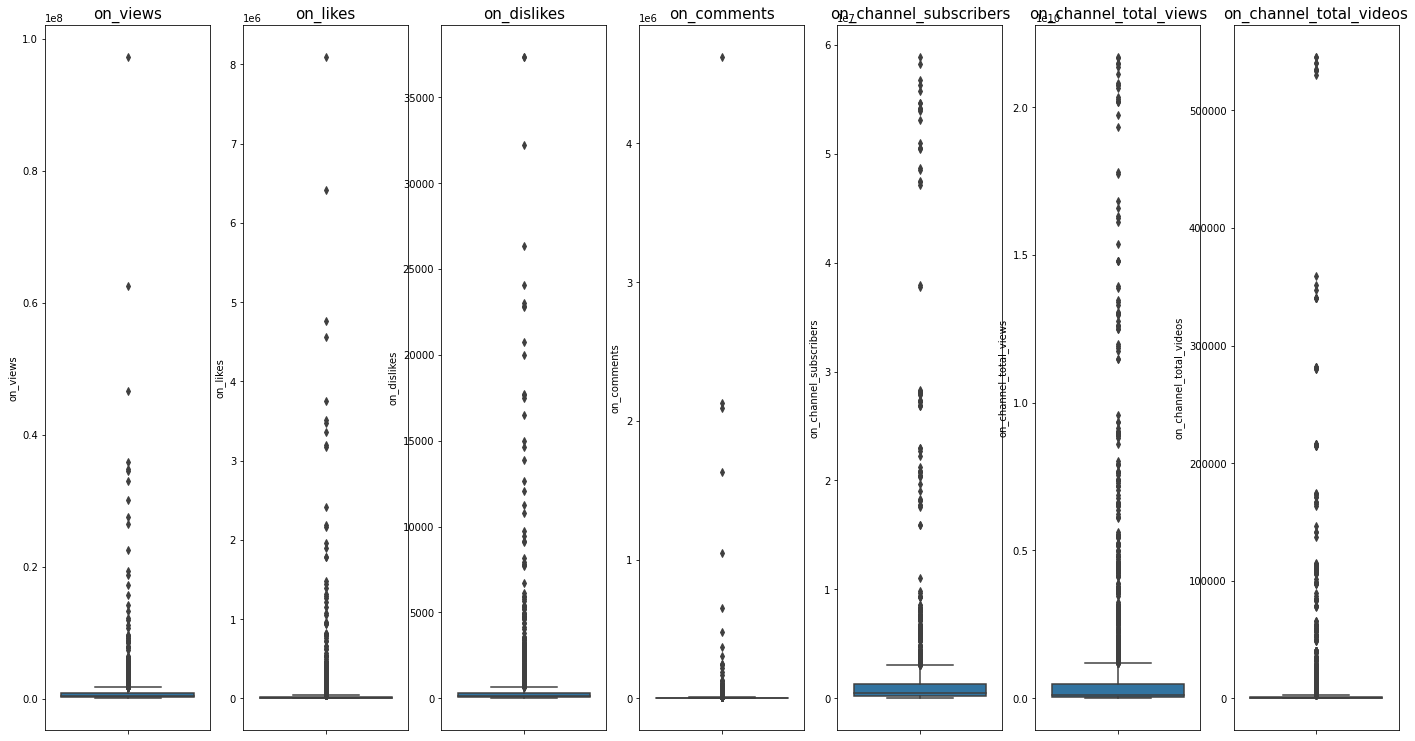

In [22]:
### 최종적으로 IQR 방식을 활용한 이상치 확인 ##

# boxplot 그려 볼 특성들의 데이터프레임 정의
cols_boxplot = ['on_views', 'on_likes', 'on_dislikes', 'on_comments', 'on_channel_subscribers', 'on_channel_total_views', 'on_channel_total_videos']
df_boxplot = df[cols_boxplot]

# boxplot 
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 10))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=None, hspace=0.2)
ax =axes.flatten()

for idx in range(len(cols_boxplot)):  
    sns.boxplot(y=cols_boxplot[idx], data=df, ax = ax[idx])
    ax[idx].set_title(cols_boxplot[idx], fontsize=15)
    
plt.show();

! 모든 특성들에 대해 Quantile 75% 값과 max(최대값)의 차이가 매우 크기 때문에 박스플롯이 기형적으로 그려지는 상황
<br>
> IQR(Inter Quantile Range) 방식으로 이상치를 확인해본다.

In [23]:
# IQR(Inter Quantile Range) 방식으로 이상치의 인덱스를 얻는 함수 정의

def get_outlier_idx(df=None, idx=None, weight=1.5):
    if (df is not None) & (idx is not None):
        # Quantile 25% / Quantile 75%
        Q1 = np.percentile(df.iloc[:, idx], 25)
        Q3 = np.percentile(df.iloc[:, idx], 75)

        # Inter Quantile Range
        IQR = Q3 - Q1
        IQR_weight = IQR * weight

        # 최소값 / 최대값
        min = Q1 - IQR_weight
        max = Q3 + IQR_weight

        # 이상치 인덱스 
        outlier_idx_min = df[df.iloc[:, idx] < min].index
        outlier_idx_max = df[df.iloc[:, idx] > max].index

        return outlier_idx_min, outlier_idx_max

In [24]:
print("  *** 특성별 min / max outliers 확인 ***")
print("\n")
for idx in range(10, len(df.columns) - 2, 2):
    outlier_idx_min, outlier_idx_max = get_outlier_idx(df=df, idx=idx)
    print(f"column_name  : {df.columns[idx]}\nmin_outliers : {len(outlier_idx_min)}\nmax_outliers : {len(outlier_idx_max)}")
    print(f"share(min)   : {round(len(outlier_idx_min) / df.shape[0] * 100, 1)}%")
    print(f"share(max)   : {round(len(outlier_idx_max) / df.shape[0] * 100, 1)}%")
    print("-----"*8)

  *** 특성별 min / max outliers 확인 ***


column_name  : off_rank
min_outliers : 3
max_outliers : 0
share(min)   : 0.1%
share(max)   : 0.0%
----------------------------------------
column_name  : off_views
min_outliers : 0
max_outliers : 222
share(min)   : 0.0%
share(max)   : 8.7%
----------------------------------------
column_name  : off_likes
min_outliers : 0
max_outliers : 328
share(min)   : 0.0%
share(max)   : 12.9%
----------------------------------------
column_name  : off_dislikes
min_outliers : 0
max_outliers : 269
share(min)   : 0.0%
share(max)   : 10.6%
----------------------------------------
column_name  : off_comments
min_outliers : 0
max_outliers : 290
share(min)   : 0.0%
share(max)   : 11.4%
----------------------------------------
column_name  : off_channel_subscribers
min_outliers : 0
max_outliers : 271
share(min)   : 0.0%
share(max)   : 10.7%
----------------------------------------
column_name  : off_channel_total_views
min_outliers : 0
max_outliers : 375
share(min)   :

- IQR 방식으로 min / max 이상치를 알아봤지만, IQR(`Q3 - Q1`) 값이 매우 크게 나타남으로써 값이 큰쪽에서만 이상치가 집계됨.
- 또한, 집계된 이상치의 개수가 전체 데이터의 (최소)9% ~ (최대)16.9%까지 차지함.
<br>

> 따라서, 이상치 제거는 전체 데이터에 큰 영향을 미칠 것으로 예상되며, 이상치를 제거하지 않는 방향으로 진행.
<br> --> **데이터를 특성 내에서 수직적으로 비교하지 않고, 특성들'끼리' 상대적으로 비교/분석**하는 방향으로 결정.

## 1.6. etc

In [25]:
# 날짜 데이터 문자열형식 -> datetime 형식 변환

def str_to_datetime(str):
    format = '%Y-%m-%d'
    dt = datetime.strptime(str, format)
    return dt

df['published_date'] = df['published_date'].apply(str_to_datetime)
df['on_trending_date'] = df['on_trending_date'].apply(str_to_datetime)
df['off_trending_date'] = df['off_trending_date'].apply(str_to_datetime)

# 2.데이터 타입별 시각화

In [26]:
# 필요 특성 추출
grouped = df[['published_date', 'category_name', 'channel_id', 'video_id', 'tags']]

# 연/월/주 열 추가
grouped = grouped.reindex(columns = grouped.columns.tolist() + ['year', 'month', 'week'])
grouped = grouped[['published_date', 'year', 'month', 'week', 'category_name', 'tags', 'channel_id', 'video_id']]

In [27]:
# 연/월/주 값 채우기

for idx in range(len(grouped)):  
    dt = grouped['published_date'][idx]

    # year, month, day : int
    year = dt.year
    month = dt.month
    day = dt.day

    # year 열 채우기
    grouped['year'][idx] = year
    
    # month 열 채우기
    grouped['month'][idx] = month
    
    # week 열 채우기
    grouped['week'][idx] = datetime(year, month, day).isocalendar()[1]


# 연/월/주 float -> int
def toInt(x):
    return int(x)

for idx in range(1, 4): #인덱스 1번 열 ~ 3번 열('year', 'month', 'week')
    grouped.iloc[:, idx] = grouped.iloc[:, idx].apply(lambda x: toInt(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
grouped

published_date  year  month  week         category_name  \
0        2021-07-01  2021      7    26         Entertainment   
1        2021-06-24  2021      6    25         Entertainment   
2        2021-07-17  2021      7    28         Entertainment   
3        2021-06-02  2021      6    22                Sports   
4        2021-07-06  2021      7    27                Sports   
...             ...   ...    ...   ...                   ...   
2539     2021-05-09  2021      5    18                Comedy   
2540     2021-07-29  2021      7    30                Comedy   
2541     2021-04-20  2021      4    16  Science & Technology   
2542     2021-04-26  2021      4    17         Entertainment   
2543     2021-06-02  2021      6    22                 Music   

                                                   tags channel_id video_id  
0     SiriusXM|Sirius XM|Sirius|SXM|BIGHIT|빅히트|방탄소년단...    CH49ta0    V-0db  
1                                       치킨불냉면|치킨|불냉면|냉면    CHZVD--    V-1XL  
2                                               missing    CH9w-h_    V-4fa  
3     News Network|SBS SPORTSMUG|SPORTSMUG|스포츠머그|축구|...    CHUQVGX    V-5ip  
4                                        이천수|심판도전기|축구심판    CHhI3EX    V-5jn  
...                                                 ...        ...      ...  
2539                         아프리카tv|봉준|와꾸대장봉준|BJ|컨텐츠|클립    CH69uMh    VzwuB  
2540  장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...    CHhbE5O    VzxuL  
2541  아이패드 프로|아이패드 프로5|아이패드 프로 5세대|신형 아이맥|아이맥|iMac|에...    CHO4RG1    VzygR  
2542  고요 속의 외침|뽕숭아학당|슬기로운캠핑생활|아는형님|미스터트롯|임영웅|영탁|장민호|...    CHYeeEw    Vzz6W  
2543  MAMAMOO|마마무|WAW|마마무 WAW|MAMAMOO WAW|Where Are ...    CHuhAUM    Vzzk0  

[2544 rows x 8 columns]

## 2.1. (전체기간) 카테고리별 채널별 비디오 개수 시각화

In [29]:
# 필요 열 선택
cols = ['category_name', 'channel_id', 'video_id']
grouped_total = grouped[cols]

# Styler 버전 : pivot_table 형태로 변환
grouped_pivot = grouped_total.groupby(by=['category_name', 'channel_id']).count().unstack().fillna(0)

# Pivot 버전 : melted 형태로 변환
grouped_melt = grouped_total.groupby(by=['category_name', 'channel_id']).count().reset_index()

In [60]:
grouped_melt

category_name channel_id  video_id
0    Autos & Vehicles    CH-IBt8         1
1    Autos & Vehicles    CH2xkO7         2
2    Autos & Vehicles    CHDpnvN         2
3    Autos & Vehicles    CHH5U89         1
4    Autos & Vehicles    CHKnKi2         1
..                ...        ...       ...
915   Travel & Events    CHPDdt9         2
916   Travel & Events    CHPll9Z         2
917   Travel & Events    CHa0aTy         2
918   Travel & Events    CHlRNDV         7
919   Travel & Events    CHsLoTw         1

[920 rows x 3 columns]

### 2.1.1. plot 버전
barh 형태의 plot으로 시각화 진행

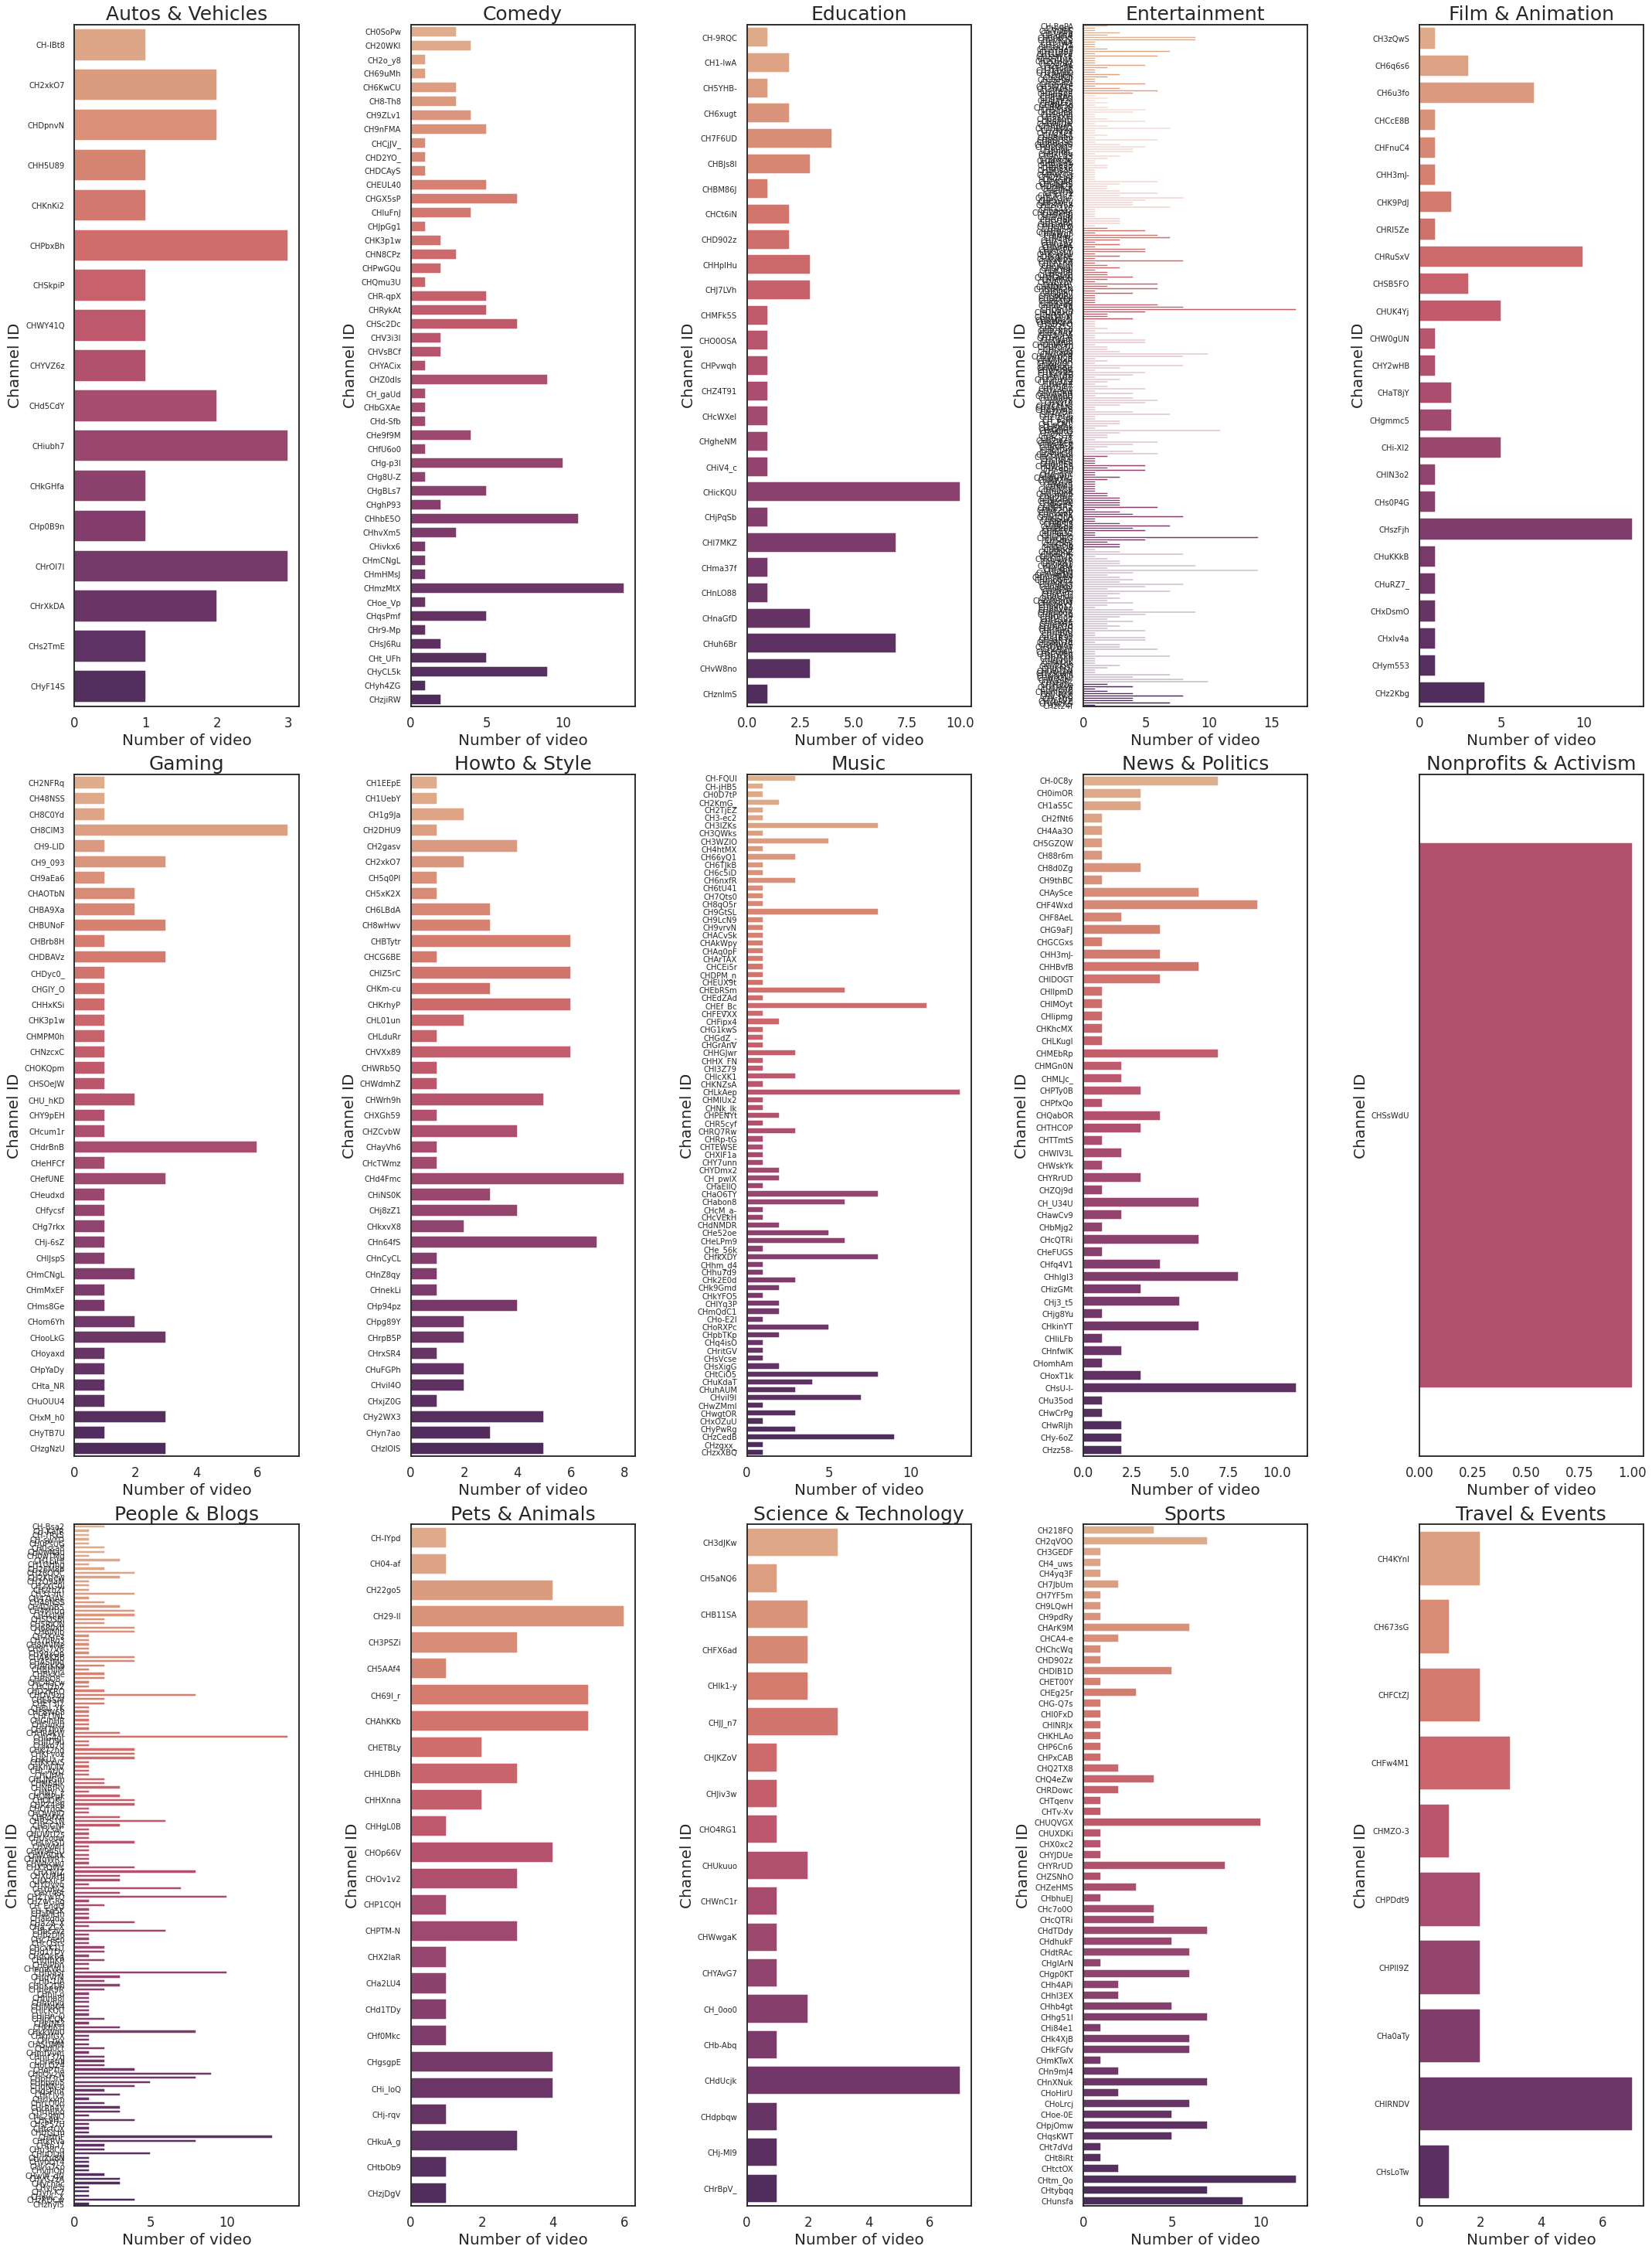

In [32]:
categories = grouped_melt['category_name'].unique()

# fig, axes
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 40))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.5, hspace=0.1)
ax = axes.flatten()

# Style
sns.set(style='white', context='talk')

# Bar plot
for idx in range(len(categories)):    
    sns.barplot(x='video_id', y='channel_id',
                data=grouped_melt[grouped_melt['category_name'] == categories[idx]],
                ax=ax[idx],
                palette="flare")
    ax[idx].set_title(f"{categories[idx]}", fontsize=25) 
    ax[idx].set_xlabel('Number of video', fontsize=20)
    ax[idx].set_ylabel('Channel ID', fontsize=20)
    ax[idx].tick_params(axis='y', labelsize=10)
    
plt.show();

### 2.1.2. dataframe styler 버전
> 판다스 Styler를 활용해 데이터프레임 형태로 시각화 진행

In [30]:
# Styler로 background gradient 효과
# => 특정 채널을 찾고 싶다면 ctrl + f -> 'channel_id' 검색

cm = sns.light_palette("blue", as_cmap=True)
grouped_pivot = grouped_pivot.style.background_gradient(cmap=cm).set_precision(0)
grouped_pivot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  """


## 2.2. (월별) 카테고리별 채널별 비디오 개수 시각화
역시 데이터프레임 버전과 플롯 버전 두가지 방식으로 진행

In [33]:
# 연도 cardinality 확인 : 2021년도만 존재
grouped['year'].value_counts()

2021    2544
Name: year, dtype: int64

### 2.2.1. plot 버전
bar 형태의 plot으로 시각화

In [51]:
cols = ['month', 'category_name', 'channel_id', 'video_id']
grouped_month = grouped[cols]
grouped_month = grouped_month.groupby(by=['month', 'category_name', 'channel_id']).count().reset_index()

months = grouped_month['month'].unique()
grouped_month

month    category_name channel_id  video_id
0         3           Comedy    CHEUL40         1
1         3           Comedy    CHV3i3l         1
2         3           Comedy    CHgBLs7         1
3         3           Comedy    CHyCL5k         1
4         3        Education    CH5YHB-         1
...     ...              ...        ...       ...
1608      7           Sports    CHpjOmw         1
1609      7           Sports    CHqsKWT         1
1610      7           Sports    CHtm_Qo         4
1611      7           Sports    CHunsfa         1
1612      7  Travel & Events    CHlRNDV         5

[1613 rows x 4 columns]

In [52]:
categories = grouped_month['category_name'].unique()
categories_and = []
categories_final = []

# 카테고리명 변경
for category in categories:
    category_and = category.replace('&', '')
    categories_and.append(category_and)

for category in categories_and:
    category_space = category.replace(' ', '')
    categories_final.append(category_space)

print(f"카테고리 종류 : {categories_final}")

카테고리 종류 : ['Comedy', 'Education', 'Entertainment', 'FilmAnimation', 'Gaming', 'HowtoStyle', 'Music', 'NewsPolitics', 'PeopleBlogs', 'PetsAnimals', 'ScienceTechnology', 'Sports', 'AutosVehicles', 'TravelEvents', 'NonprofitsActivism']
카테고리별 데이터프레임 생성 완료!
변경된 카테고리 명 : ['Comedy' 'Education' 'Entertainment' 'FilmAnimation' 'Gaming'
 'HowtoStyle' 'Music' 'NewsPolitics' 'PeopleBlogs' 'PetsAnimals'
 'ScienceTechnology' 'Sports' 'AutosVehicles' 'TravelEvents'
 'NonprofitsActivism']
월             : [3, 4, 5, 6, 7]
[('Comedy', 3), ('Comedy', 4), ('Comedy', 5), ('Comedy', 6), ('Comedy', 7), ('Education', 3), ('Education', 4), ('Education', 5), ('Education', 6), ('Education', 7), ('Entertainment', 3), ('Entertainment', 4), ('Entertainment', 5), ('Entertainment', 6), ('Entertainment', 7), ('FilmAnimation', 3), ('FilmAnimation', 4), ('FilmAnimation', 5), ('FilmAnimation', 6), ('FilmAnimation', 7), ('Gaming', 3), ('Gaming', 4), ('Gaming', 5), ('Gaming', 6), ('Gaming', 7), ('HowtoStyle', 3), ('HowtoSty

60

In [ ]:
# 각 카레고리 이름을 변수로 활용한 데이터프레임 생성
for idx in range(len(categories)):
    globals()['{}'.format(categories[idx])] = grouped_month[grouped_month['category_name'] == categories[idx]]
print("카테고리별 데이터프레임 생성 완료!")

# 변경된 카테고리명으로 매핑
mapping = {cat:cat_new for cat, cat_new in zip(categories, categories_final)}
grouped_month = grouped_month.replace({'category_name' : mapping})

categories = grouped_month['category_name'].unique()
months = [3, 4, 5, 6, 7]
print(f"변경된 카테고리 명 : {categories}")
print(f"월             : {months}")

# category_month 형태의 변수명으로 데이터프레임 생성
for category in categories:
    for idx in range(len(months)):
        globals()['{}_{}'.format(category, months[idx])] = grouped_month[(grouped_month['category_name'] == category) & (grouped_month['month'] == months[idx])]

In [61]:
Entertainment_7

month  category_name channel_id  video_id
1296      7  Entertainment    CH0PsUG         2
1297      7  Entertainment    CH0VR2v         2
1298      7  Entertainment    CH1L79y         1
1299      7  Entertainment    CH1cWTE         1
1300      7  Entertainment    CH2DHU9         1
...     ...            ...        ...       ...
1414      7  Entertainment    CHxLc0z         2
1415      7  Entertainment    CHy-NrX         1
1416      7  Entertainment    CHy-swB         3
1417      7  Entertainment    CHybPxZ         3
1418      7  Entertainment    CHyozK5         2

[123 rows x 4 columns]

In [ ]:
# 데이터가 너무 적은 category_name 삭제
categories = list(categories)
categories.remove('NonprofitsActivism')
categories.remove('AutosVehicles')
categories.remove('TravelEvents')

#(category, month) 튜플로 구성된 리스트 생성
months = list(months)
months_eng = ['March', 'April', 'May', 'June', 'July']

cat_mon = []
for cat in categories:
    for mon in months:
        cat_mon.append((cat, mon))

cat_mon_eng = []
for cat in categories:
    for mon in months_eng:
        cat_mon_eng.append((cat, mon))

print(cat_mon)
print(cat_mon_eng)
len(cat_mon)

In [53]:
# 한글깨짐 방지
plt.rc('font', family='NanumBarunGothic') 

# fig, axes
fig, axes = plt.subplots(nrows=len(categories), ncols=len(months), figsize=(30, 100))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.5, hspace=0.5)
ax = axes.flatten()

# Style
sns.set(style='white', context='talk')

# Barh plot
for idx in range(len(categories)*len(months)):
    sns.barplot(x='video_id',
                y='channel_id',
                data=globals()['{}_{}'.format(cat_mon[idx][0], cat_mon[idx][1])],
                ax=ax[idx],
                palette="flare"
                )
    ax[idx].set_title(cat_mon_eng[idx][1], fontsize=25) 
    ax[idx].set_xlabel(cat_mon[idx][0], fontsize=20)
    ax[idx].set_ylabel('')
    ax[idx].tick_params(axis='x', labelsize=15)
    ax[idx].tick_params(axis='y', labelsize=15)

plt.show();

Output hidden; open in https://colab.research.google.com to view.

### 2.2.2. dataframe styler 버전
> 판다스 Styler를 활용해 데이터프레임 형태로 시각화 진행

In [34]:
# 월 확인
cols = ['month', 'category_name', 'channel_id', 'video_id']
grouped_month = grouped[cols]
grouped_month = grouped_month.groupby(by=['month', 'category_name', 'channel_id']).count().reset_index()
grouped_month['month'].unique()

array([3, 4, 5, 6, 7])

In [35]:
# 3월
grouped_march = grouped_month[grouped_month['month'] == 3]
grouped_march = grouped_march.groupby(by=['month', 'category_name', 'channel_id']).count().unstack().fillna(0)

# 4월
grouped_april = grouped_month[grouped_month['month'] == 4]
grouped_april = grouped_april.groupby(by=['month', 'category_name', 'channel_id']).count().unstack().fillna(0)

# 5월
grouped_may = grouped_month[grouped_month['month'] == 5]
grouped_may = grouped_may.groupby(by=['month', 'category_name', 'channel_id']).count().unstack().fillna(0)

# 6월
grouped_june = grouped_month[grouped_month['month'] == 6]
grouped_june = grouped_june.groupby(by=['month', 'category_name', 'channel_id']).count().unstack().fillna(0)

# 7월
grouped_july = grouped_month[grouped_month['month'] == 7]
grouped_july = grouped_july.groupby(by=['month', 'category_name', 'channel_id']).count().unstack().fillna(0)

In [36]:
# Styler로 background gradient 효과
# => 특정 채널을 찾고 싶다면 ctrl + f -> 'channel_id' 검색
cm = sns.light_palette("green", as_cmap=True)

#3월
grouped_march.style.background_gradient(cmap=cm).set_precision(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


In [37]:
# 4월
grouped_april.style.background_gradient(cmap=cm).set_precision(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


In [38]:
# 5월
grouped_may.style.background_gradient(cmap=cm).set_precision(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


In [39]:
# 6월
grouped_june.style.background_gradient(cmap=cm).set_precision(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


In [40]:
# 7월
grouped_july.style.background_gradient(cmap=cm).set_precision(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  


## 2.3. (월별) TOP10 채널 (분류 기준은 비디오 개수)

In [54]:
# 필요 특성 추출
cols = ['month', 'channel_id', 'video_id']
grouped_top10 = grouped_month[cols]
grouped_top10 = grouped_top10.groupby(['month', 'channel_id']).count().reset_index()

In [55]:
# 월별 top10 데이터프레임
top10_march = grouped_top10[grouped_top10['month'] == 3].sort_values('video_id', ascending=False).head(10)
top10_april = grouped_top10[grouped_top10['month'] == 4].sort_values('video_id', ascending=False).head(10)
top10_may = grouped_top10[grouped_top10['month'] == 5].sort_values('video_id', ascending=False).head(10)
top10_june = grouped_top10[grouped_top10['month'] == 6].sort_values('video_id', ascending=False).head(10)
top10_july = grouped_top10[grouped_top10['month'] == 7].sort_values('video_id', ascending=False).head(10)

# 3월~7월 데이터프레임 concat
top10_by_month = pd.concat([top10_march, top10_april, top10_may, top10_june, top10_july])
print(f"월별 top10 채널 데이터 수 : {len(top10_by_month)}개")

월별 top10 채널 데이터 수 : 50개


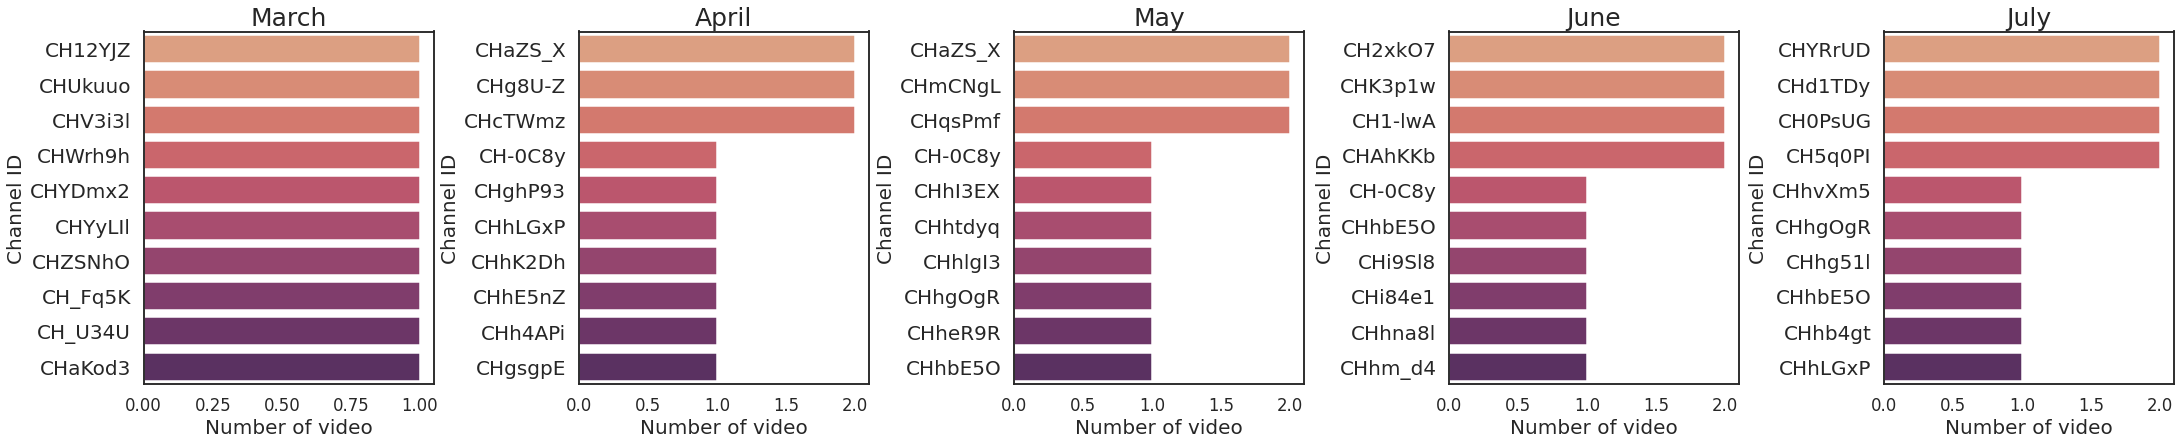

In [56]:
# title 지정을 위한 month 값 매핑
mapping = {3:'March', 4:'April', 5:'May', 6:'June', 7:'July'}
top10_by_month = top10_by_month.replace({'month' : mapping})

# month 값
months = top10_by_month['month'].unique()

# fig, axes
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(30, 5))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.5, hspace=None)
ax = axes.flatten()

# Style
sns.set(style='white', context='talk')

# Bar plot
for idx in range(len(months)):    
    sns.barplot(x='video_id', y='channel_id',
                data=top10_by_month[top10_by_month['month'] == months[idx]],
                ax=ax[idx],
                palette="flare")
    ax[idx].set_title(f"{months[idx]}", fontsize=25) 
    ax[idx].set_xlabel('Number of video', fontsize=20)
    ax[idx].set_ylabel('Channel ID', fontsize=20)
    ax[idx].tick_params(axis='y', labelsize=20)
    
plt.show();

## 2.4. (주별) TOP5 채널 (분류 기준은 비디오 개수)

In [57]:
cols = ['week', 'channel_id', 'video_id']
grouped_week = grouped[cols]
grouped_top5 = grouped_week.groupby(by=['week', 'channel_id']).count().reset_index()

In [58]:
weeks = grouped_top5['week'].unique()
print(f"주차   : {weeks}")
print(f"주차 수 : {len(weeks)}")

# 주별 top5 데이터프레임 생성
for idx in range(len(weeks)):
    globals()['top5_{}'.format(weeks[idx])] = grouped_top5[grouped_top5['week'] == weeks[idx]].sort_values('video_id', ascending=False).head()

# 주별 top5 데이터프레임 concat
for idx in range(min(weeks), max(weeks)): #12 ~29
    globals()['top5_{}'.format(idx + 1)] = pd.concat([globals()['top5_{}'.format(idx)], globals()['top5_{}'.format(idx + 1)]])

top5_by_week = top5_30

# top10_by_month = pd.concat([top10_march, top10_april, top10_may, top10_june, top10_july])
print(f"주별 top5 채널 데이터 수 : {len(top5_by_week)}개")

주차   : [12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30]
주차 수 : 19
주별 top5 채널 데이터 수 : 95개


In [59]:
top5_by_week

week channel_id  video_id
13      12    CHnet0I         2
0       12    CH2qVOO         1
1       12    CH7Krez         1
2       12    CHCA4-e         1
3       12    CHGiqkg         1
...    ...        ...       ...
2163    30    CHYRrUD         5
2131    30    CH-FQUI         3
2172    30    CHcQTRi         3
2181    30    CHkinYT         2
2164    30    CHYZv9v         2

[95 rows x 3 columns]

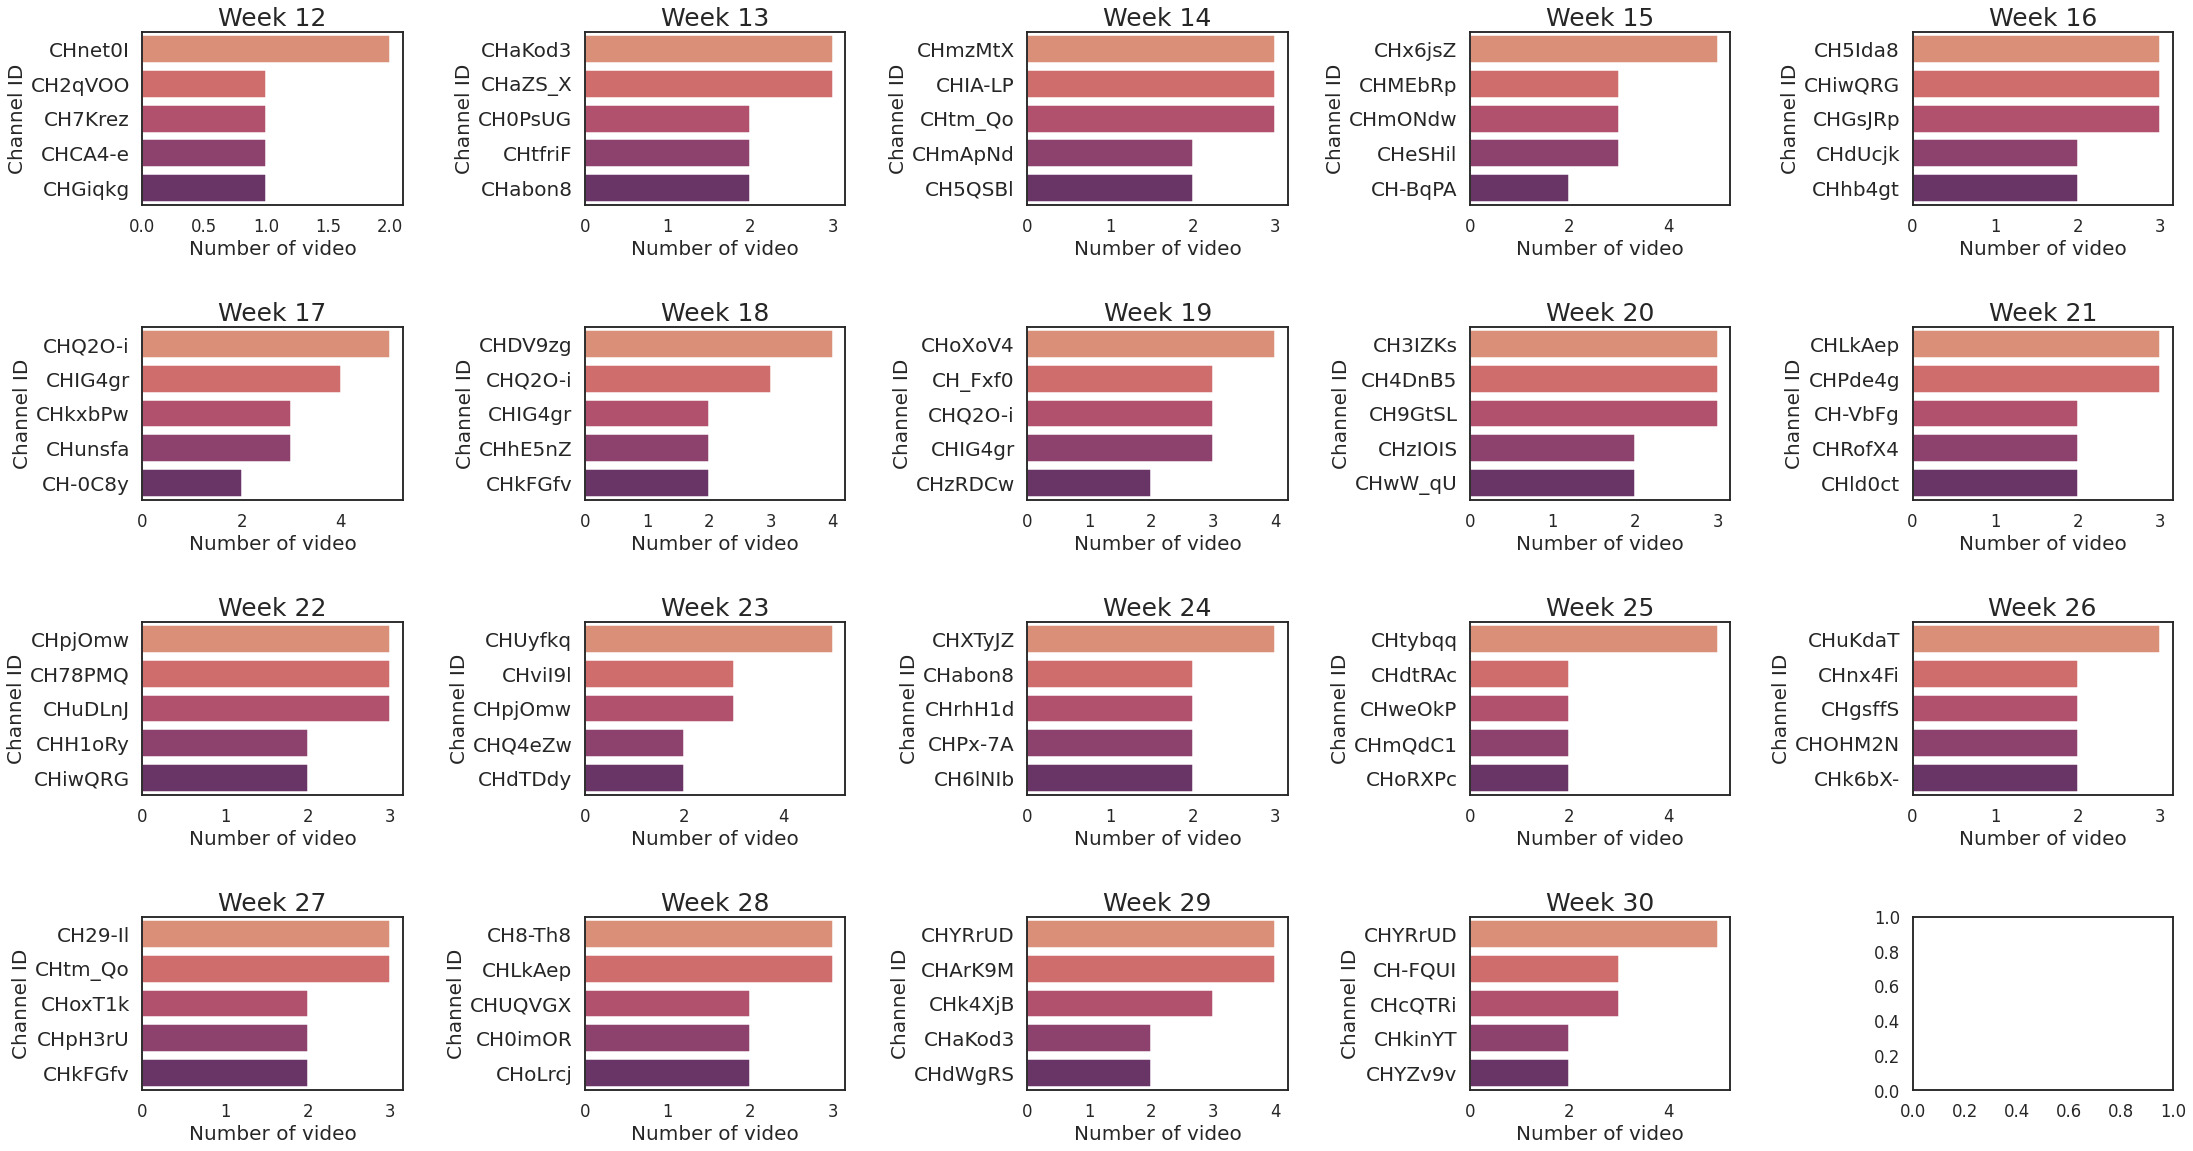

In [ ]:
# week 값
weeks = top5_by_week['week'].unique()

# fig, axes
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(30, 15))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.7, hspace=0.7)
ax = axes.flatten()

# Style
sns.set(style='white', context='talk')

# Barh plot
for idx in range(len(weeks)):    
    sns.barplot(x='video_id', y='channel_id',
                data=top5_by_week[top5_by_week['week'] == weeks[idx]],
                ax=ax[idx],
                palette="flare")
    ax[idx].set_title(f"Week {weeks[idx]}", fontsize=25) 
    ax[idx].set_xlabel('Number of video', fontsize=20)
    ax[idx].set_ylabel('Channel ID', fontsize=20)
    ax[idx].tick_params(axis='y', labelsize=20)
    
plt.show();

## 2-5. (월별) 카테고리별 태그 키워드 순위

In [ ]:
# 필요 특성 추출
cols = ['month', 'category_name', 'tags']
grouped_tags = grouped[cols]

# 토큰 값을 받기 위한 열 생성
grouped_tags['tokens'] = pd.Series()

# tags -> tokenizing
for idx in range(len(grouped_tags)):  
    token = re.compile('[A-Za-z가-힣]+').findall(grouped_tags['tags'][idx])
    grouped_tags['tokens'][idx] = token
    lower = []
    # 대문자 -> 소문자
    for token in grouped_tags['tokens'][idx]:
        lower.append(token.lower())
        grouped_tags['tokens'][idx] = lower

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/pandas/core/indexin

In [ ]:
grouped_tags

month         category_name  \
0         7         Entertainment   
1         6         Entertainment   
2         7         Entertainment   
3         6                Sports   
4         7                Sports   
...     ...                   ...   
2539      5                Comedy   
2540      7                Comedy   
2541      4  Science & Technology   
2542      4         Entertainment   
2543      6                 Music   

                                                   tags  \
0     SiriusXM|Sirius XM|Sirius|SXM|BIGHIT|빅히트|방탄소년단...   
1                                       치킨불냉면|치킨|불냉면|냉면   
2                                               missing   
3     News Network|SBS SPORTSMUG|SPORTSMUG|스포츠머그|축구|...   
4                                        이천수|심판도전기|축구심판   
...                                                 ...   
2539                         아프리카tv|봉준|와꾸대장봉준|BJ|컨텐츠|클립   
2540  장삐쭈|삐쭈|ㅋㅋㅋ|삐쮸|장삐쮸|병맛더빙|더빙|웃긴동영상|꿀잼|신병|장삐쭈 단편선|...   
2541  아이패드 프로|아이패드 프로5|아이패드 프로 5세대|신형 아이맥|아이맥|iMac|에...   
2542  고요 속의 외침|뽕숭아학당|슬기로운캠핑생활|아는형님|미스터트롯|임영웅|영탁|장민호|...   
2543  MAMAMOO|마마무|WAW|마마무 WAW|MAMAMOO WAW|Where Are ...   

                                                 tokens  
0     [siriusxm, sirius, xm, sirius, sxm, bighit, 빅히...  
1                                  [치킨불냉면, 치킨, 불냉면, 냉면]  
2                                             [missing]  
3     [news, network, sbs, sportsmug, sportsmug, 스포츠...  
4                                    [이천수, 심판도전기, 축구심판]  
...                                                 ...  
2539                  [아프리카tv, 봉준, 와꾸대장봉준, bj, 컨텐츠, 클립]  
2540  [장삐쭈, 삐쭈, 삐쮸, 장삐쮸, 병맛더빙, 더빙, 웃긴동영상, 꿀잼, 신병, 장삐...  
2541  [아이패드, 프로, 아이패드, 프로, 아이패드, 프로, 세대, 신형, 아이맥, 아이...  
2542  [고요, 속의, 외침, 뽕숭아학당, 슬기로운캠핑생활, 아는형님, 미스터트롯, 임영웅...  
2543  [mamamoo, 마마무, waw, 마마무, waw, mamamoo, waw, wh...  

[2544 rows x 4 columns]

In [ ]:
categories = grouped_tags['category_name'].unique()
categories_and = []
categories_final = []

# 카테고리명 변경
for category in categories:
    category_and = category.replace('&', '')
    categories_and.append(category_and)

for category in categories_and:
    category_space = category.replace(' ', '')
    categories_final.append(category_space)

print(f"카테고리 종류 : {categories_final}")

# 각 카레고리 이름을 변수로 활용한 데이터프레임 생성
for idx in range(len(categories)):
    globals()['{}'.format(categories[idx])] = grouped_tags[grouped_tags['category_name'] == categories[idx]]
print("카테고리별 데이터프레임 생성 완료!")

카테고리 종류 : ['Entertainment', 'Sports', 'Music', 'PeopleBlogs', 'ScienceTechnology', 'Education', 'HowtoStyle', 'NewsPolitics', 'Gaming', 'Comedy', 'PetsAnimals', 'TravelEvents', 'FilmAnimation', 'AutosVehicles', 'NonprofitsActivism']
카테고리별 데이터프레임 생성 완료!


In [ ]:
# 변경된 카테고리명으로 매핑
mapping = {cat:cat_new for cat, cat_new in zip(categories, categories_final)}
grouped_tags = grouped_tags.replace({'category_name' : mapping})

categories = grouped_tags['category_name'].unique()
months = [3, 4, 5, 6, 7]
print(f"변경된 카테고리 명 : {categories}")
print(f"월             : {months}")

변경된 카테고리 명 : ['Entertainment' 'Sports' 'Music' 'PeopleBlogs' 'ScienceTechnology'
 'Education' 'HowtoStyle' 'NewsPolitics' 'Gaming' 'Comedy' 'PetsAnimals'
 'TravelEvents' 'FilmAnimation' 'AutosVehicles' 'NonprofitsActivism']
월             : [3, 4, 5, 6, 7]


In [ ]:
# category_month 형태의 변수명으로 데이터프레임 생성
for category in categories:
    for idx in range(len(months)):
        globals()['{}_{}'.format(category, months[idx])] = grouped_tags[(grouped_tags['category_name'] == category) & (grouped_tags['month'] == months[idx])]

In [ ]:
# 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 반환하는 함수 정의
def word_count(docs):
    """ 
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    # wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [ ]:
# 각 카테고리별 월별로 나뉘어진 데이터프레임에 함수 적용
for category in categories:
    for month in months:
        # top 10 ranked word 추출
        globals()['wc_{}_{}'.format(category, month)] = word_count(globals()['{}_{}'.format(category, month)]['tokens']).head(10)

In [ ]:
# 결측치였던 'missing' 토큰은 제외
def remove_missing_rank(wc):
    missing = wc[wc['word'] == 'missing'].index
    wc.drop(missing, inplace=True)

for category in categories:
    for month in months:
        remove_missing_rank(globals()['wc_{}_{}'.format(category, month)])

print("         -----  word count 데이터프레임 예시  -----\n")
wc_Entertainment_3

         -----  word count 데이터프레임 예시  -----



word  word_in_docs  count  rank   percent  cul_percent
53     kbs             4     13   1.0  0.018310     0.018310
255     혜리             1     12   2.0  0.016901     0.035211
100     tv             2     10   3.0  0.014085     0.049296
410   미스트롯             1     10   4.0  0.014085     0.063380
93   world             2      8   5.0  0.011268     0.074648
271     놀토             1      8   6.0  0.011268     0.085915
67      먹방             3      7   7.0  0.009859     0.095775
120  korea             2      6   8.0  0.008451     0.104225
95     eng             3      6   9.0  0.008451     0.112676
97       k             3      5  10.0  0.007042     0.119718

In [ ]:
# 데이터가 너무 적은 category_name 삭제
categories = list(categories)
categories.remove('NonprofitsActivism')
categories.remove('AutosVehicles')
categories.remove('TravelEvents')

#(category, month) 튜플로 구성된 리스트 생성
months = list(months)
months_eng = ['March', 'April', 'May', 'June', 'July']

cat_mon = []
for cat in categories:
    for mon in months:
        cat_mon.append((cat, mon))

cat_mon_eng = []
for cat in categories:
    for mon in months_eng:
        cat_mon_eng.append((cat, mon))

print(cat_mon)
print(cat_mon_eng)
len(cat_mon)

[('Entertainment', 3), ('Entertainment', 4), ('Entertainment', 5), ('Entertainment', 6), ('Entertainment', 7), ('Sports', 3), ('Sports', 4), ('Sports', 5), ('Sports', 6), ('Sports', 7), ('Music', 3), ('Music', 4), ('Music', 5), ('Music', 6), ('Music', 7), ('PeopleBlogs', 3), ('PeopleBlogs', 4), ('PeopleBlogs', 5), ('PeopleBlogs', 6), ('PeopleBlogs', 7), ('ScienceTechnology', 3), ('ScienceTechnology', 4), ('ScienceTechnology', 5), ('ScienceTechnology', 6), ('ScienceTechnology', 7), ('Education', 3), ('Education', 4), ('Education', 5), ('Education', 6), ('Education', 7), ('HowtoStyle', 3), ('HowtoStyle', 4), ('HowtoStyle', 5), ('HowtoStyle', 6), ('HowtoStyle', 7), ('NewsPolitics', 3), ('NewsPolitics', 4), ('NewsPolitics', 5), ('NewsPolitics', 6), ('NewsPolitics', 7), ('Gaming', 3), ('Gaming', 4), ('Gaming', 5), ('Gaming', 6), ('Gaming', 7), ('Comedy', 3), ('Comedy', 4), ('Comedy', 5), ('Comedy', 6), ('Comedy', 7), ('PetsAnimals', 3), ('PetsAnimals', 4), ('PetsAnimals', 5), ('PetsAnimals'

60

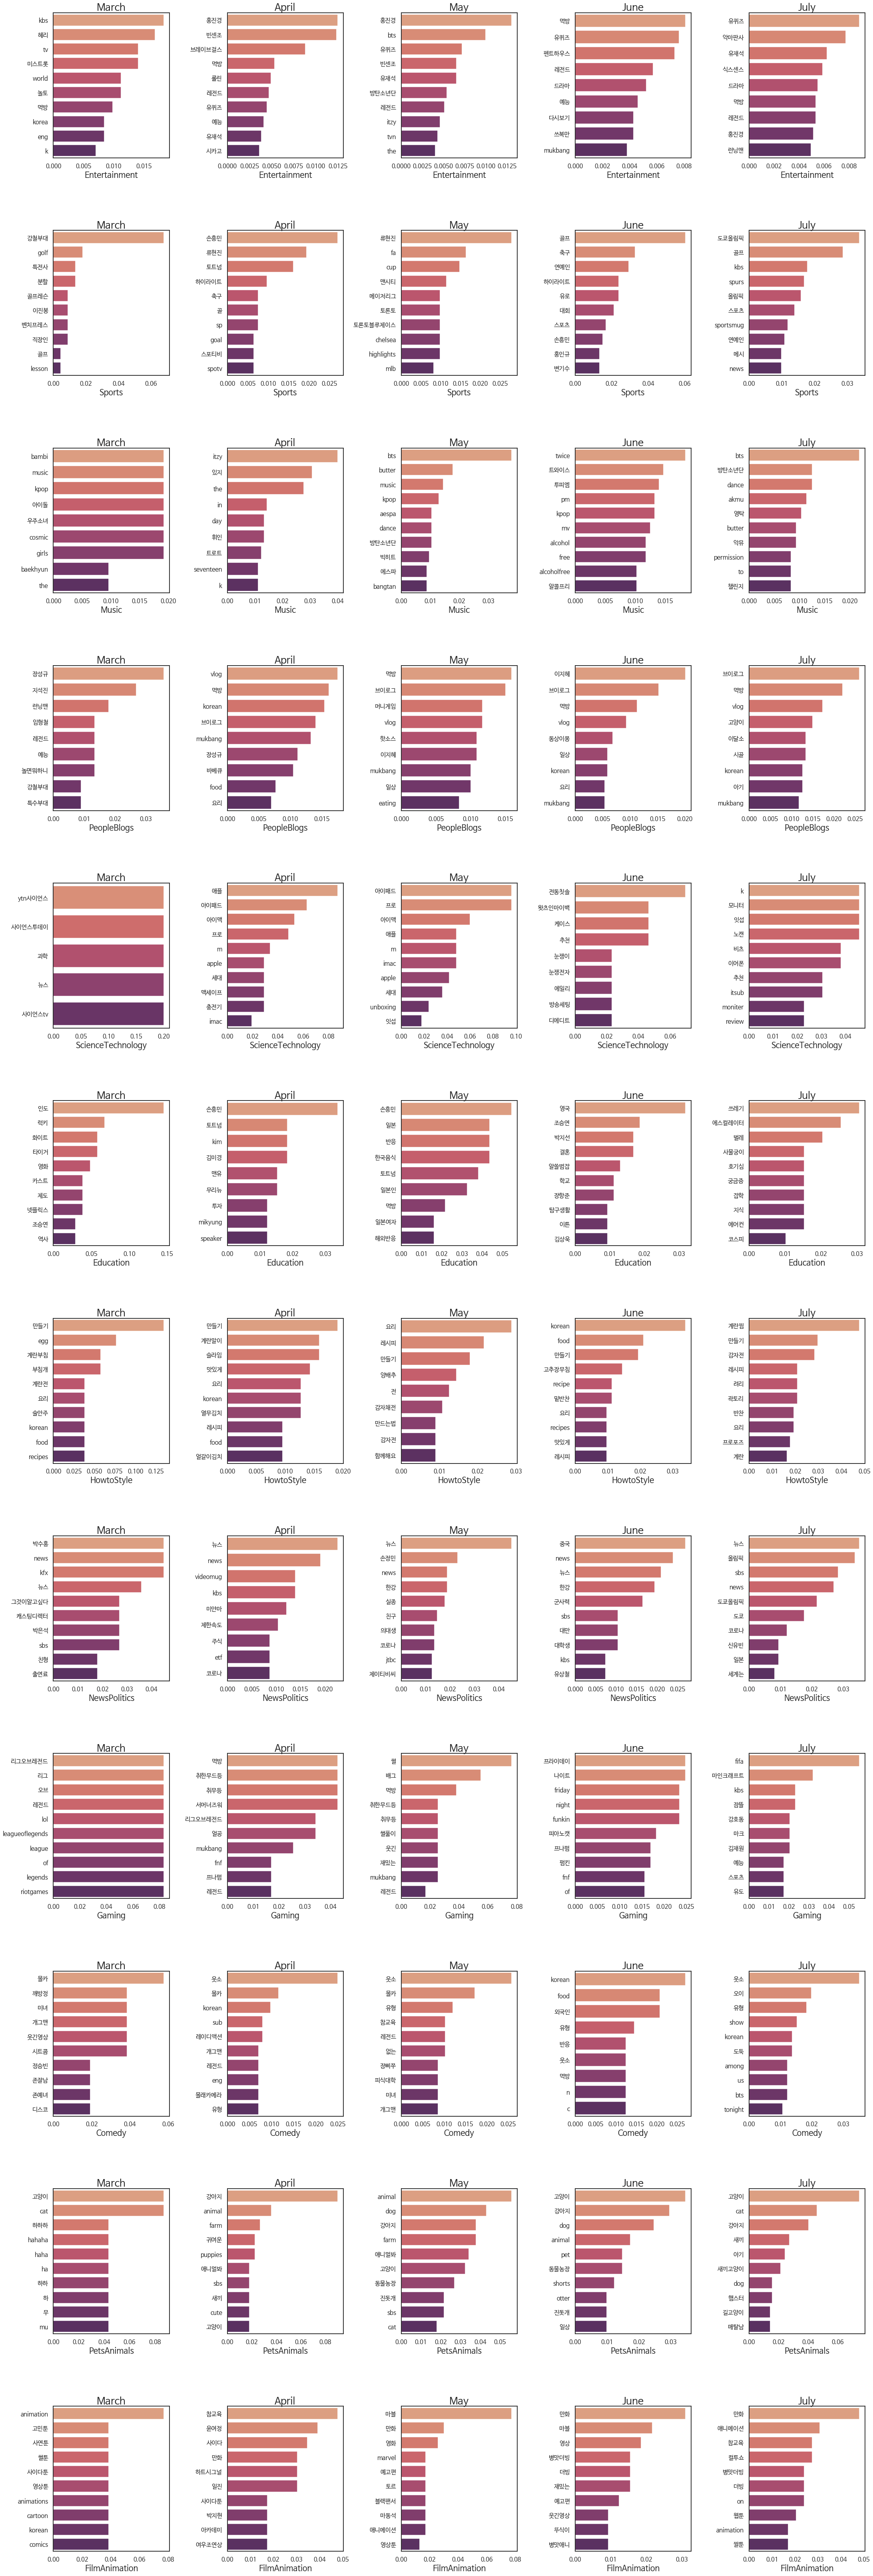

In [ ]:
# 한글깨짐 방지
plt.rc('font', family='NanumBarunGothic') 

# fig, axes
fig, axes = plt.subplots(nrows=len(categories), ncols=len(months), figsize=(30, 90))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.5, hspace=0.5)
ax = axes.flatten()

# Style
sns.set(style='white', context='talk')

# Barh plot
for idx in range(len(categories)*len(months)):
    sns.barplot(x='percent',
                y='word',
                data=globals()['wc_{}_{}'.format(cat_mon[idx][0], cat_mon[idx][1])],
                ax=ax[idx],
                palette="flare"
                )
    ax[idx].set_title(cat_mon_eng[idx][1], fontsize=25) 
    ax[idx].set_xlabel(cat_mon[idx][0], fontsize=20)
    ax[idx].set_ylabel('')
    ax[idx].tick_params(axis='x', labelsize=15)
    ax[idx].tick_params(axis='y', labelsize=15)

plt.show();

# 3.새로운 지표 개발 (Feature Engineering)
- 1) 비디오를 인기 동영상 기준에 부합하도록 분류할 수 있는 새로운 지표 개발
- 2) 해당 지표를 사용하여 engagement와 어떤 상관관계가 있는지 설명

## 3.1. engagement 지표 1차 가공
- 인기동영상 섹션에 오르기 위한 중요한 지표는 `views, likes, dislikes, comments` 로 예상
- 부가적인 지표로 영상 길이 `duration` 지표 활용<br>
- 각 비디오별로 상대적인 비교가 가능하도록 각 지표를 가공

In [ ]:
# 특징벡터에 활용될 지표들의 통계치 확인
cols = ['on_views', 'on_likes', 'on_dislikes', 'on_comments', 'on_channel_subscribers', 'on_channel_total_videos']
df_engagement = df[cols]
df_engagement.describe().astype('int')

on_views  on_likes  on_dislikes  on_comments  on_channel_subscribers  \
count      2544      2544         2544         2544                    2544   
mean     956679     55827          537         9285                 1792517   
std     3248054    329941         2098       117771                 5634920   
min       53297       423            5            1                     499   
25%      238498      4319           89          520                  165750   
50%      429635      7915          162         1161                  482500   
75%      831281     16929          317         2720                 1312500   
max    97276666   8097173        37349      4625133                58900000   

       on_channel_total_videos  
count                     2544  
mean                      9608  
std                      43962  
min                          1  
25%                        121  
50%                        329  
75%                       1265  
max                     545577

1. engagement 지표 `(views, likes, dislikes, comments)`<br>
각 engagement 지표들의 전반적인 통계 수치 특히, 각 표준편차가 큰 값을 가지는 상황이다 (이는 데이터의 흩어짐이 크다고 할 수 있다).<br>
> 같은 인기동영상일지라도 각각의 engagement 값의 크기에는 큰 차이가 있기 때문에 이를 아무런 가공 없이 인기동영상의 기준으로 활용하기에는 무리가 있다.<br>
> 따라서, 이 지표들을 상대적인 관점으로 볼 수 있는 새로운 지표를 만든다. 
2. 채널 비디오 개수 / 채널 구독자 수<br>
채널의 전체 비디오 수와 채널 구독자 수는 인기동영상에 오르는데 큰 영향이 없다고 말할 수 있다.
> 비디오가 많든 적든, 구독자가 많든 적든 다양한 비디오가 인기동영상 섹션에 오른다는 것을 통계치를 바탕으로 알 수 있다.

In [ ]:
### 신규 지표 생성 ###

# 구독자 대비 조회수
view_per_sub = [round(view / subs, 5) for view, subs in zip(df['on_views'], df['on_channel_subscribers'])]

# 조회수 대비 좋아요수
like_per_view = [round(like / view, 5) for like, view in zip(df['on_likes'], df['on_views'])]

# 좋아요수 대비 싫어요수
dislike_per_like = [round(dislike / like, 5) for dislike, like in zip(df['on_dislikes'], df['on_likes'])]

# 조회수 대비 댓글수 
comment_per_view = [round(comment / view, 5) for comment, view in zip(df['on_comments'], df['on_views'])]

# 데이터프레임 생성
df_engagement = pd.DataFrame(data={'category_name':df['category_name'],
                                   'duration':df['duration'].astype('float'),
                                   'view_per_sub':view_per_sub,
                                   'like_per_view':like_per_view,
                                   'dislike_per_like':dislike_per_like,
                                   'comment_per_view':comment_per_view})

df_engagement

category_name  duration  view_per_sub  like_per_view  \
0            Entertainment     500.0       1.53656        0.16270   
1            Entertainment     557.0       0.46820        0.02426   
2            Entertainment     459.0       0.07848        0.00885   
3                   Sports     400.0       2.29773        0.00535   
4                   Sports     687.0      13.26887        0.00608   
...                    ...       ...           ...            ...   
2539                Comedy     154.0       1.12654        0.00293   
2540                Comedy     399.0       0.71826        0.01953   
2541  Science & Technology     705.0       0.80974        0.01232   
2542         Entertainment     687.0       0.34343        0.03057   
2543                 Music     266.0       0.55418        0.12393   

      dislike_per_like  comment_per_view  
0              0.00293           0.00625  
1              0.01699           0.00369  
2              0.04056           0.00154  
3              0.02591           0.00192  
4              0.02917           0.00109  
...                ...               ...  
2539           6.84968           0.01690  
2540           0.01363           0.00864  
2541           0.06310           0.00740  
2542           0.02141           0.00225  
2543           0.00466           0.01785  

[2544 rows x 6 columns]

## 3.2. 최종 지표 - 차원축소 / 2차원 특징벡터 생성
- 가공된 지표로 벡터화 (비디오별 특징 벡터 생성)
- 차원축소를 통해 2차원 공간에 projection
- 카테고리별로 scatter plot을 확인하며 인기동영상들이 이루는 공간좌표 확인

In [ ]:
# 데이터 표준화(Standardization)
scaler = StandardScaler()
standardized = scaler.fit_transform(df_engagement.iloc[:,1:])

# 표준화 데이터로 데이터프레임 생성
df_standardized = pd.DataFrame(data=standardized,
                               columns=['duration',	'view_per_sub', 'like_per_view', 'dislike_per_like', 'comment_per_view'])
df_standardized['category_name'] = df_engagement['category_name']
df_standardized = df_standardized[['category_name', 'duration', 'view_per_sub', 'like_per_view',	'dislike_per_like', 'comment_per_view']]

df_standardized

category_name  duration  view_per_sub  like_per_view  \
0            Entertainment -0.264874     -0.067225       3.227000   
1            Entertainment -0.157293     -0.087143      -0.200484   
2            Entertainment -0.342256     -0.094409      -0.582003   
3                   Sports -0.453612     -0.053034      -0.668656   
4                   Sports  0.088068      0.151510      -0.650583   
...                    ...       ...           ...            ...   
2539                Comedy -0.917909     -0.074869      -0.728570   
2540                Comedy -0.455500     -0.082481      -0.317589   
2541  Science & Technology  0.122041     -0.080775      -0.496094   
2542         Entertainment  0.088068     -0.089469      -0.044262   
2543                 Music -0.706522     -0.085540       2.267136   

      dislike_per_like  comment_per_view  
0            -0.131906          0.366551  
1            -0.078763         -0.094257  
2             0.010325         -0.481263  
3            -0.045048         -0.412862  
4            -0.032726         -0.562264  
...                ...               ...  
2539         25.746952          2.283582  
2540         -0.091463          0.796758  
2541          0.095520          0.573554  
2542         -0.062057         -0.353461  
2543         -0.125367          2.454584  

[2544 rows x 6 columns]

In [ ]:
# PCA(Principle Component Analysis) : 5차원 -> 2차원 차원축소 진행
nparray = df_standardized.iloc[:,1:].to_numpy()

pca = PCA(2) #2차원으로 축소
reduced = pca.fit_transform(nparray)

# PCA 이후 최종지표 PC1, PC2 (2차원 공간좌표)
df_reduced = pd.DataFrame(data=reduced, columns=['PC1', 'PC2'])
df_reduced['category_name'] = df_engagement['category_name']
df_reduced = df_reduced[['category_name', 'PC1', 'PC2']]
df_reduced

category_name       PC1        PC2
0            Entertainment  2.543516  -0.301186
1            Entertainment -0.167725  -0.005480
2            Entertainment -0.649379   0.196288
3                   Sports -0.632638   0.245661
4                   Sports -0.843040   0.180931
...                    ...       ...        ...
2539                Comedy  0.948711  12.970848
2540                Comedy  0.427659   0.014593
2541  Science & Technology  0.008870  -0.101485
2542         Entertainment -0.295668  -0.084987
2543                 Music  3.399126  -0.316527

[2544 rows x 3 columns]

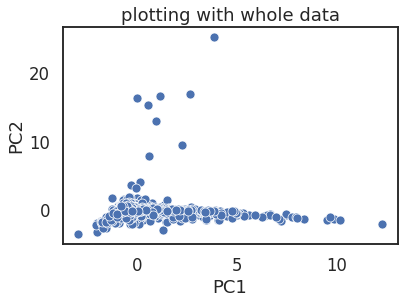

In [ ]:
# 전체데이터 대상 scatter plot 
ax = sns.scatterplot(x='PC1', y='PC2', data=df_reduced)
ax.set_title('plotting with whole data')
plt.show();

전체데이터를 대상으로 scatter plot을 그려보면 데이터가 어느정도 밀집되어 있는 형태를 확인할 수 있다.<br>
인기동영상이 아닌 다른 동영상들에 대한 데이터가 있고, 이를 동일한 지표로 차원축소를 진행할 경우 위와는 다른 위치에 밀집될 것으로 '예상'한다.

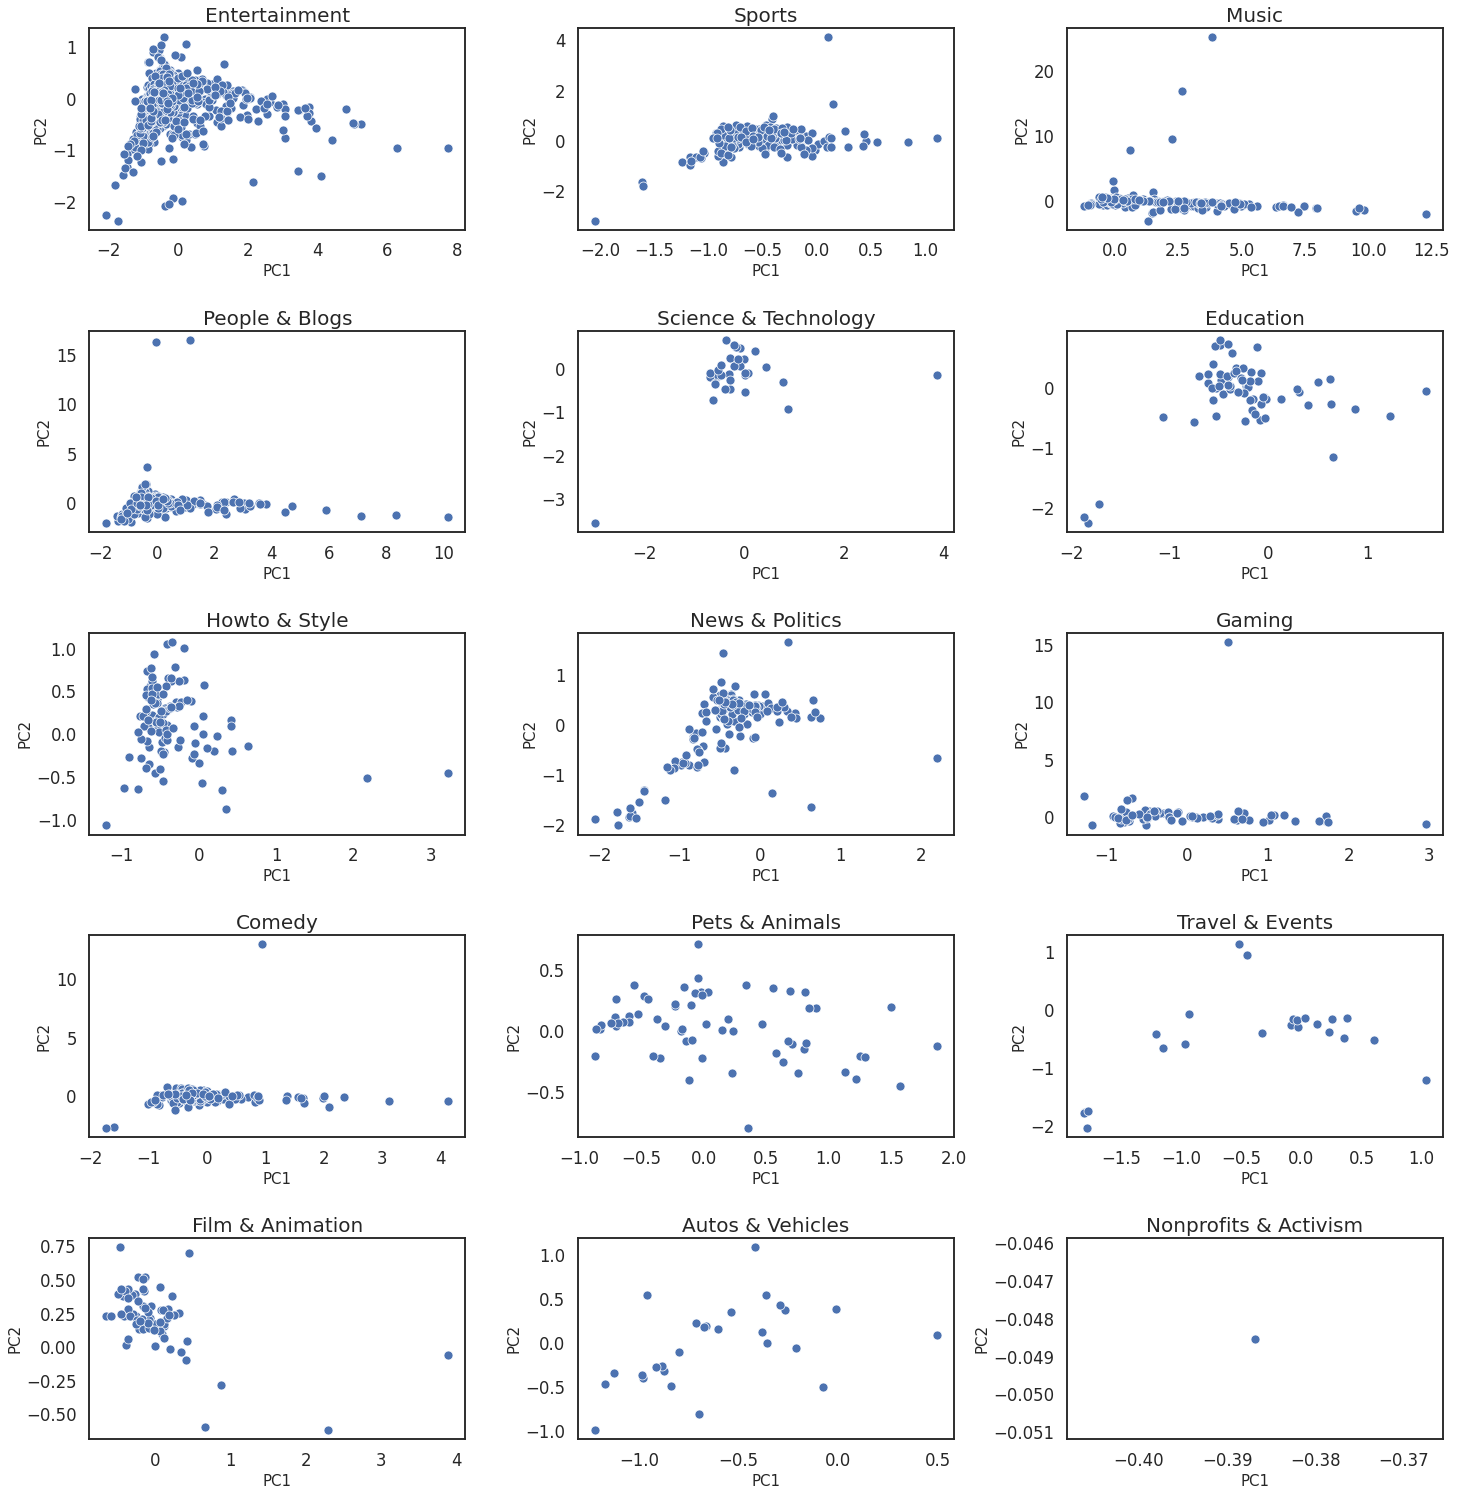

In [ ]:
# 카테고리별 scatter plots
categories = df_reduced['category_name'].unique()

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))
plt.subplots_adjust(left=0.05, bottom=0.01, right=0.99, top=0.99, wspace=0.3, hspace=0.5)
ax =axes.flatten()

for idx in range(len(categories)):
    sns.scatterplot(x='PC1', y='PC2', data=df_reduced[df_reduced['category_name'] == categories[idx]], ax=ax[idx])
    ax[idx].set_title(categories[idx], fontsize=20)
    ax[idx].set_xlabel('PC1', fontsize=15)
    ax[idx].set_ylabel('PC2', fontsize=15)
       
plt.show();

대부분의 카테고리에서 각각의 벡터들이 특정 위치에 밀집된 형태를 확인할 수 있다.<br>
역시, 각 카테고리 별로 인기동영상이 아닌 다른 동영상에 대한 데이터가 있었다면 이들은 해당 카테고리 내의 인기동영상과는 다른 위치에 밀집 혹은 밀집되지 못하는 형태를 가질 것으로 예상할 수 있다.

> `Pets & Animals / Travel & Events / Autos & Vehicles / Nonprofit & Activism`과 같은 카테고리의 데이터는 뚜렷한 특징을 갖지 않는데, 데이터수가 많아진다면 다른 카테고리처럼 특정 위치에 벡터들이 모일 것으로 '예상'해본다.